# **Модуль А.** Анализ и предобработка данных

## Импортирование библиотек

In [2]:
# для работы с файловой системой
import os

# для работы с раширением tar
import tarfile

# для работы с датафреймами
import pandas as pd
# для работы с датасетами
from datasets import Dataset

# для прослушивания примеров 
from IPython.display import Audio

# для анализа звуковых дорожек
import librosa

# для визуализации результатов
import matplotlib.pyplot as plt
import librosa.display

# для работы с массивами
import numpy as np

# для создания прогресс бара
from tqdm import tqdm

# модель для извлечения эмбеддингов
from transformers import WhisperFeatureExtractor

## Загрузка данных

In [3]:
# создаем папку для данных
os.makedirs('Data', exist_ok=True)

# получаем пути к архивам с данными
cv_corpus = '../Data/cv-corpus-21.0-delta-2025-03-14-ru.tar.gz'
ljspeech = '../Data/LJSpeech-1.1.tar.bz2'
ru_ru = '../Data/ru_RU.tgz'

Открываем первый архив

In [4]:
# открываем первый архив используя библиотеку tarfile
with tarfile.open(cv_corpus, 'r:gz') as tar:
    # распаковываем архив
    tar.extractall('Data/cv_corpus')

In [5]:
# получаем путь к папке с данными
data_path = 'Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14/ru/'

# получаем путь к папке с записями
clips_path = os.path.join(data_path, 'clips')
# получаем кол-во записей в папке
print(f'Кол-во записей в первой папке: {len(os.listdir(clips_path))}')

Кол-во записей в первой папке: 3034


Общее кол-во файлов с записями - `3034`

In [6]:
# создаем датафрейм
df = pd.read_csv(os.path.join(data_path, 'other.tsv'), sep='\t')[['path', 'sentence']]
# размер датасета
print(df.shape)
# выводим первые 5 строк
df.head()

(2940, 2)


,path,sentence
0,common_voice_ru_41910911.mp3,"Абай был не только талантливым поэтом, но и уч..."
1,common_voice_ru_41910912.mp3,Гибкая кошка легко взбирается на высокое дерево.
2,common_voice_ru_41910913.mp3,"Мы выступаем за такой Совет Безопасности, в ко..."
3,common_voice_ru_41910914.mp3,Сделать нужно гораздо больше.
4,common_voice_ru_41910915.mp3,"Эти ноты, сливаясь воедино, образуют симфонию,..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   path      2940 non-null   object
 1   sentence  2940 non-null   object
dtypes: object(2)
memory usage: 46.1+ KB


Добавление колонок с длительностью записи и частотой дискретизацией

In [8]:
sampling_rate = []
record_duration = []
arrays = []
# проходимся по каждой строчке в дф
for i in tqdm(range(df.shape[0]), desc='Парсим данные..', unit='record'):
    # получаем путь к записи
    sample_path = os.path.join(data_path, 'clips', df['path'].loc[i])
    # получаем временной ряд и частоту дискретизации
    y, sr = librosa.load(sample_path, sr=None)
    # добавляем частоту дискретизации
    sampling_rate.append(sr)
    # добавляем массив
    arrays.append(y)
    # добавляем длительность записи
    record_duration.append(round(len(y)/sr, 2))


Парсим данные..: 100%|██████████| 2940/2940 [01:16<00:00, 38.45record/s]


In [9]:
# добавляем новые колонки в датафрейм
df['record_duration'] = record_duration
df['sampling_rate'] = sampling_rate
df['array'] = arrays
# выводим первые 3 строки
df.head(3)

,path,sentence,record_duration,sampling_rate,array
0,common_voice_ru_41910911.mp3,"Абай был не только талантливым поэтом, но и уч...",5.04,32000,"[0.0, -2.0297514e-12, -4.6083987e-12, -5.01278..."
1,common_voice_ru_41910912.mp3,Гибкая кошка легко взбирается на высокое дерево.,5.65,32000,"[0.0, 5.2995247e-12, 1.64486e-11, -1.395177e-1..."
2,common_voice_ru_41910913.mp3,"Мы выступаем за такой Совет Безопасности, в ко...",7.67,32000,"[0.0, 1.6022399e-11, 1.9621242e-11, 6.006008e-..."


Вывожу график отображающий разброс длительности записи

<Axes: >

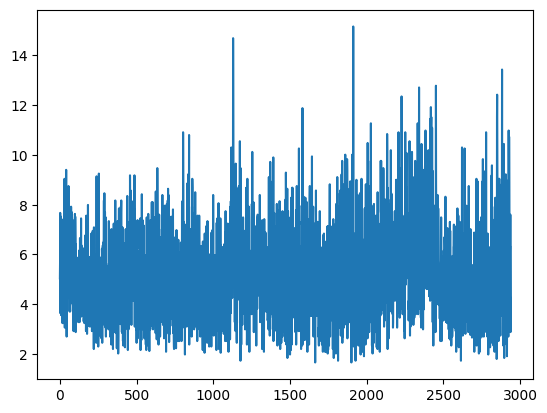

In [10]:
df['record_duration'].plot()

видно, что имеются некоторые выбросы (например >14 секунд), поэтому я отфильтрую датасет, оставив записи в диапазоне от 2 до 8 секунд:

(2678, 5)


<Axes: >

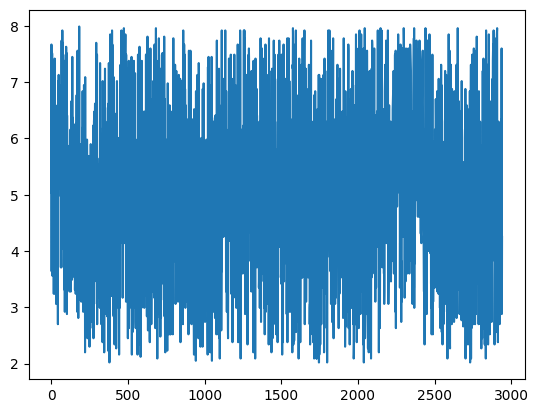

In [11]:
df_filtered = df[(df['record_duration'] > 2) & (df['record_duration'] < 8)]
print(df_filtered.shape)
df_filtered['record_duration'].plot()

Форма волны звука:

In [12]:
file_path = os.path.join(data_path, 'clips', df_filtered.loc[0]['path'])
print(os.path.exists(file_path))

True


**Частота дискретизации** - кол-во выборок, сделанных за 1 секунду измеряемое в герцах `(Гц)`

In [13]:
array, sampling_rate = librosa.load(file_path, sr=None)     # где array - временной ряд звука, 
                                                            # и sampling_rate - частота дискретизации

print(f'Частота дискретизации: {sampling_rate} Гц')
print(f'Длительность записи: {len(array)/sampling_rate:.2f} сек')

Частота дискретизации: 32000 Гц
Длительность записи: 5.04 сек


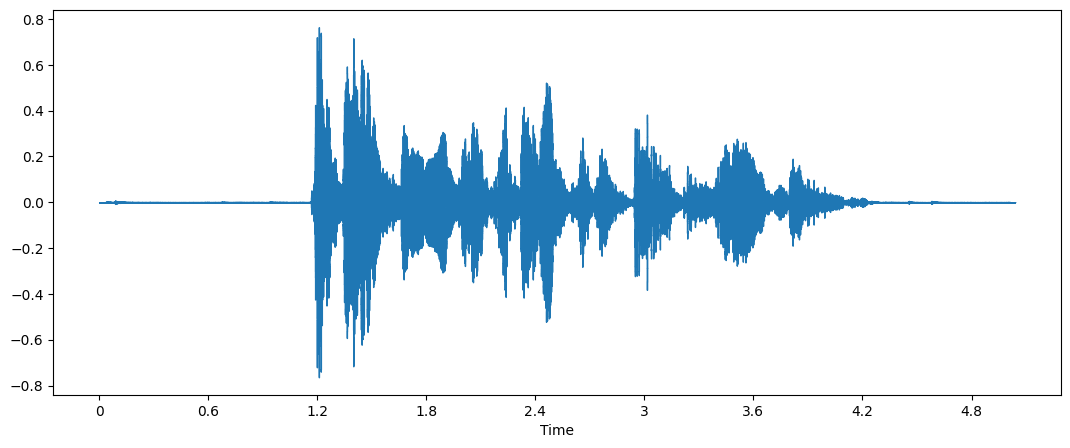

In [14]:
plt.figure(figsize=(13,5))
librosa.display.waveshow(array, sr=sampling_rate)

**Частотный спектр** *(частотный интервал)* - вычисляется с помощью `ДПФ` `(дискретное преобразование Фурье)`, описывает `отдельные частоты`, из которых состоит сигнал, и их `силы`

In [15]:
dft_input = array[:4096]

# высчитываем ДПФ (DFT - Discrete Fourier Transform)
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

In [16]:
# получаем амплитудный спектр в децибелах
amplitude = np.abs(dft) 
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

In [17]:
# получим частотные столбцы
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

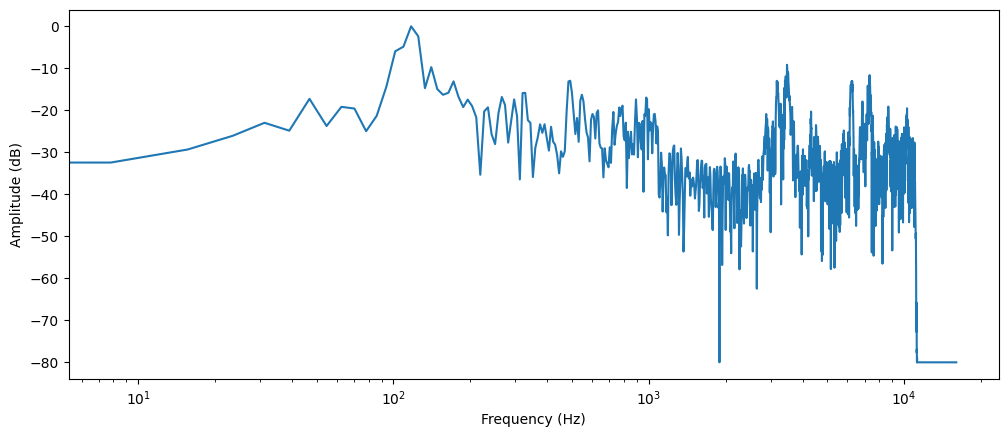

In [18]:
# визуализируем результат
plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.xscale('log')

**Спектограмма** - несколько `ДПФ`, каждый из которых охватывает небольшой отрезок времени. Представляет собой график изменения частотного содержания звукового сигнала во времни. 

Она `позволяет увидеть время`, `частоту`, и `амплитуду` на одном графике. Алгоритм, выполняющий эти вычисления, назвается `ОПФ - Оконное Преобразование Фурье` *(Short Time Fourier Transform - `STFT`)* 

In [19]:
D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

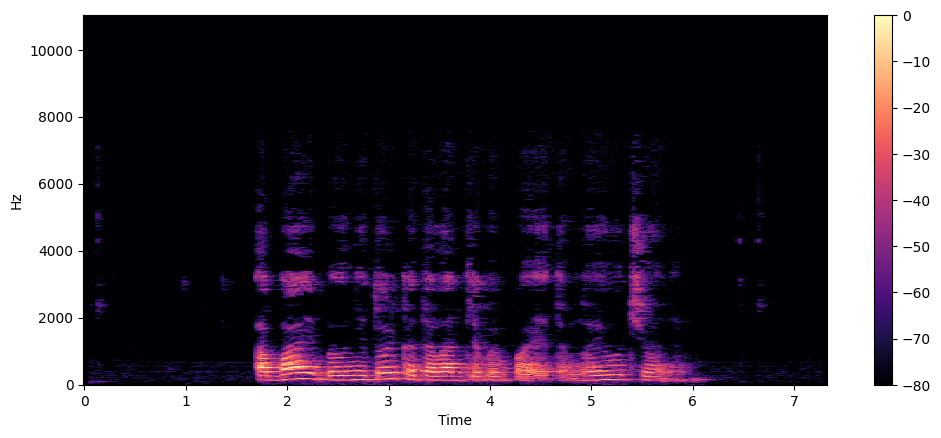

In [20]:
plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis='time', y_axis='hz')
plt.colorbar()

**Мэл спектограмма** - разновидность спектрограммы, показывает частотное содержание аудиосигнала во времени, но на другой частотной оси. Это перцептивная шкала, которая аппроксимирует нелинейную частотную хар-ку человеческого уха

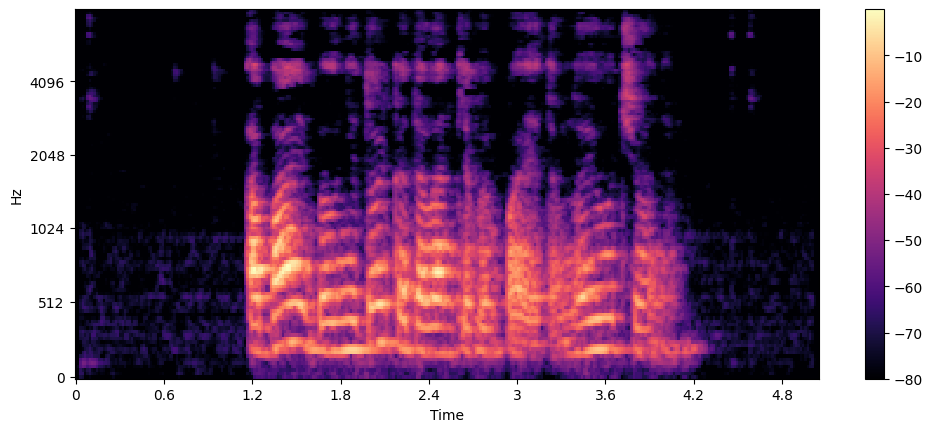

In [21]:
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=sampling_rate, fmax=8000)
plt.colorbar()

Меняем пути на полные (строющиеся от папки `Data`)

In [22]:
df_filtered.loc[:, 'path'] = df_filtered['path'].apply(lambda x: os.path.join(data_path, 'clips', x))


In [23]:
df_filtered

,path,sentence,record_duration,sampling_rate,array
0,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Абай был не только талантливым поэтом, но и уч...",5.04,32000,"[0.0, -2.0297514e-12, -4.6083987e-12, -5.01278..."
1,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Гибкая кошка легко взбирается на высокое дерево.,5.65,32000,"[0.0, 5.2995247e-12, 1.64486e-11, -1.395177e-1..."
2,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Мы выступаем за такой Совет Безопасности, в ко...",7.67,32000,"[0.0, 1.6022399e-11, 1.9621242e-11, 6.006008e-..."
3,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Сделать нужно гораздо больше.,3.64,32000,"[0.0, 6.653513e-12, -3.9828835e-11, -2.5098045..."
4,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Эти ноты, сливаясь воедино, образуют симфонию,...",6.62,32000,"[0.0, 2.2444215e-11, 9.745327e-12, -1.7855759e..."
...,...,...,...,...,...
2935,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Ты, поп, галок попугай, попугая не пугай.",4.14,32000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2936,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Беспристрастный анализ любого творческого акта...,7.60,32000,"[0.0, 1.2270847e-13, 1.2566264e-13, 5.730505e-..."
2937,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Он поспешно поставил гири.,2.88,32000,"[0.0, 1.4026239e-15, 5.3812537e-15, -2.0353575..."
2938,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Я руковожу большим учреждением.,2.99,32000,"[0.0, 1.29968464e-14, 2.8752357e-14, 3.375704e..."


Преобразуем `pd.DataFrame` в `Dataset`

In [24]:
dataset = Dataset.from_pandas(df_filtered).remove_columns(['__index_level_0__'])
dataset

Dataset({
    features: ['path', 'sentence', 'record_duration', 'sampling_rate', 'array'],
    num_rows: 2678
})

In [30]:
Audio(array, rate=sampling_rate)

Извлечение эмбеддингов из звукового ряда

In [26]:
feature_extractor = WhisperFeatureExtractor.from_pretrained('openai/whisper-small')

Функция для предварительной обработки аудиопримера

In [35]:
def resample_audio(sample):
    waveform, orig_sr = sample["array"], sample["sampling_rate"]
    
    if orig_sr != 16000:
        waveform = librosa.resample(np.array(waveform), orig_sr=orig_sr, target_sr=16000)

    return {"array": waveform, "sampling_rate": 16000}

In [27]:
# функция для обработки массива
def prepare_dataset(sample):
    features = feature_extractor(
        sample['array'],
        sampling_rate = sample['sampling_rate'],
        padding=True
        )
    return features

In [36]:
dataset = dataset.map(resample_audio)
dataset

Map:   0%|          | 0/2678 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'sentence', 'record_duration', 'sampling_rate', 'array'],
    num_rows: 2678
})

In [37]:
dataset = dataset.map(prepare_dataset)
dataset

Map:   0%|          | 0/2678 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'sentence', 'record_duration', 'sampling_rate', 'array', 'input_features'],
    num_rows: 2678
})

Вот так просто мы получили `лог-мел спектрограммы` в качестве `input_features` в наборе данных.

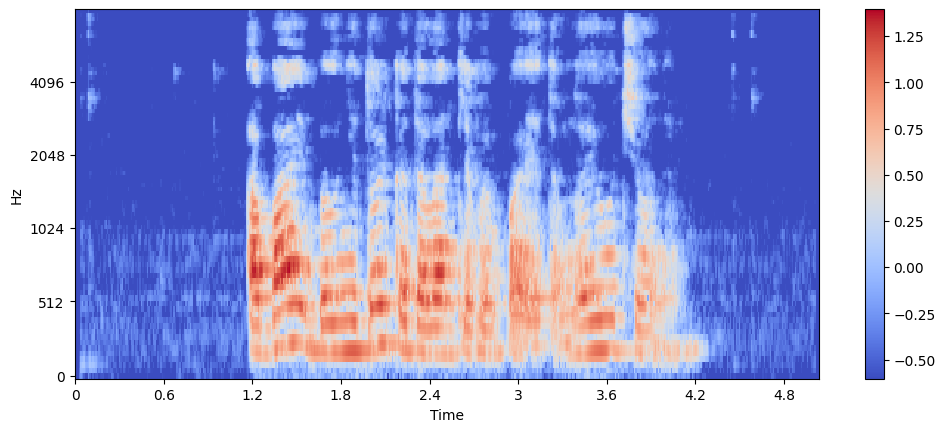

In [39]:
example = dataset[0]
input_features = example['input_features']

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis = 'time',
    y_axis = 'mel',
    sr = feature_extractor.sampling_rate,
    hop_length = feature_extractor.hop_length,
)
plt.colorbar()

Теперь вы можете увидеть, как выглядит входной аудиосигнал для модели `Whisper` после `препроцессинга`.

In [41]:
Audio(example['array'], rate=example['sampling_rate'])

In [ ]:
# TODO 
# - потоковую загрузку данных (для контроля памяти)